# Exploratory Data Analysis

### import requirements

In [1]:
# import library
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

### load dataset
Source: [Book Crossing dataset](https://www.kaggle.com/arashnic/book-recommendation-dataset) obtained from Kaggle

In [2]:
df = pd.read_csv('books/Ratings.csv')
df.head(3)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


### data preprocessing

In [3]:
df.columns = ['uid', 'bid', 'rating']

In [4]:
df.shape

(1149780, 3)

In [5]:
num_users = len(set(df['uid']))
num_books = len(set(df['bid']))
print(f'There are {num_users} users and {num_books} books in this dataset.')

There are 105283 users and 340556 books in this dataset.


In [6]:
df.isnull().sum()

uid       0
bid       0
rating    0
dtype: int64

In [7]:
df['rating'].describe()

count    1.149780e+06
mean     2.866950e+00
std      3.854184e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

In [8]:
df['rating'].value_counts()

0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: rating, dtype: int64

In [9]:
df['rating'].value_counts()[0]/df.shape[0]

0.6228226269373272

More than half of our data do not have ratings, and we will have to drop them.

In [10]:
df.shape[0]-df['rating'].value_counts()[0]

433671

In [11]:
indices0 = df[df['rating']==0].index
df1 = df.drop(indices0)

In [12]:
df1.shape

(433671, 3)

After dropping the data without ratings, we still have `433671` entries, which is sufficient for us to build a recommender system.

**P.S.** It is important to note that for the purpose of collaborative filtering, I have to drop data without ratings, but for example, if we are building recommender systems using other methods such as content-based algorithm, we can keep these entries.

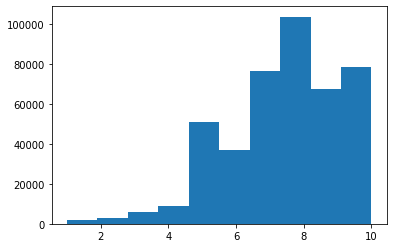

In [13]:
plt.hist(df1['rating'])
plt.show()

In [14]:
df1['rating'].describe()

count    433671.000000
mean          7.601066
std           1.843798
min           1.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: rating, dtype: float64

Books without ratings or having users that never rated a book is the common issue in ecommerce businesses about **"cold-start"**, which item-based collabortative filtering suffer. That is why we need matrix factorization, content-based, popularity methods as complimentary solutions for recommender systems. 

In [15]:
book_rating_count = df1.groupby('bid').size().sort_values(ascending=False)

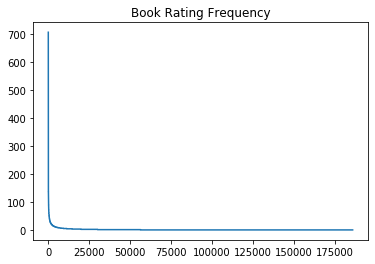

In [16]:
plt.plot(list(book_rating_count))
plt.title('Book Rating Frequency')
plt.show()

This distribution is referred to as the "long-tail property", where only a small fraction of the items are rated frequently. Those items are referred to as popular items. 

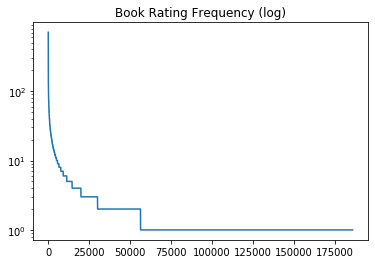

In [17]:
plt.plot(list(book_rating_count))
plt.yscale('log')
plt.title('Book Rating Frequency (log)')
plt.show()

We can see that less than 25,000 out of 175,000 books are rated more than 10 times. 

In [18]:
#book_rating_count.quantile(np.arange(1, 0.6, -0.05))
book_rating_count.quantile(np.arange(1, 0.95, -0.005))

1.000    707.0
0.995     34.0
0.990     22.0
0.985     16.0
0.980     13.0
0.975     11.0
0.970     10.0
0.965      8.0
0.960      8.0
0.955      7.0
0.950      6.0
dtype: float64

Around 1% of books have 707 or more ratings, 5% have 6 or more. 

We can do the same for understanding users.

In [19]:
user_rating_count = df1.groupby('uid').size().sort_values(ascending=False)

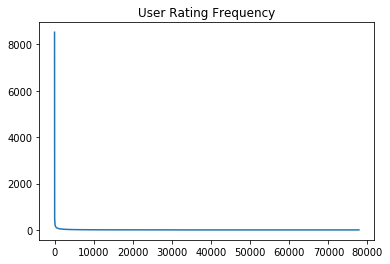

In [20]:
plt.plot(list(user_rating_count))
plt.title('User Rating Frequency')
plt.show()

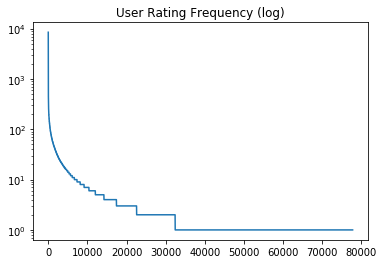

In [21]:
plt.plot(list(user_rating_count))
plt.yscale('log')
plt.title('User Rating Frequency (log)')
plt.show()

In [22]:
#user_rating_count.quantile(np.arange(1, 0.6, -0.05))
user_rating_count.quantile(np.arange(1, 0.95, -0.005))

1.000    8524.0
0.995     118.0
0.990      73.0
0.985      55.0
0.980      44.0
0.975      36.0
0.970      30.0
0.965      26.0
0.960      23.0
0.955      21.0
0.950      19.0
dtype: float64

Around 1% of users have given 8,524 or more ratings, 5% have 19 or more.

We also need to drop users who have rated less than 5 books and books that have less than 10 ratings. (The threshold is set arbitrarily based on our analysis above)

In [23]:
# books which has received 30 or more ratings
df2 = df1.groupby("bid").filter(lambda x:x['rating'].count()>=10)
df2.shape

(143110, 3)

In [24]:
# users which has given 5 or more ratings
df3 = df2.groupby("uid").filter(lambda x:x['rating'].count()>=5)
df3.shape

(92449, 3)

In [25]:
df3.shape[0]/df.shape[0]

0.08040581676494633

After all the preprocessing, we only have `8%` left of our original data size, which is a managable size to deal with, but also means that this approach is not good enough and that we need other complementary approaches.

In [26]:
num_users = len(set(df3['uid']))
num_books = len(set(df3['bid']))
print(f'There are {num_users} users and {num_books} books left in the dataset.')

There are 6029 users and 5633 books left in the dataset.


In [27]:
#df3.to_csv('ratings_item1.csv')

How is rating=0 different from no rating? My assumption is that each entry means that there was a transaction. So rating=0 means the user bought the book but didn't give a rating. While books without rating from user at all means they don't have any interaction. In other words, data with rating=0 shouldn't be dropped from the dataset.

In [28]:
# books which has received 30 or more ratings
df4 = df.groupby("bid").filter(lambda x:x['rating'].count()>=10)
df4.shape

(536630, 3)

In [29]:
# users which has given 5 or more ratings
df5 = df4.groupby("uid").filter(lambda x:x['rating'].count()>=5)
df5.shape

(456182, 3)

In [30]:
df5.shape[0]/df.shape[0]

0.3967559011289116

When keeping rating=0, we got to keep almost `40%` of our data.

In [31]:
num_users = len(set(df5['uid']))
num_books = len(set(df5['bid']))
print(f'There are {num_users} users and {num_books} books left in the dataset.')

There are 13808 users and 18318 books left in the dataset.


In [32]:
#df5.to_csv('ratings_item0.csv')

With these dataset we can start working on collaborative filtering in our next notebook.